# Rappel de la mission 
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de remboursement d'un pret de façon automatique

# Importation des librairies 

In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import imblearn
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import lightgbm as lgb
import shap


In [2]:
pd.set_option('display.max_column', 127)
pd.set_option('display.max_row', 22551)

In [3]:
data_log = pd.read_csv('../credit-default-risk/X_poly.csv',index_col='SK_ID_CURR', nrows=153755)
data_feat = pd.read_csv('../credit-default-risk/X_features.csv',index_col='SK_ID_CURR', nrows=153755)

# Suppression de colonne 
data_log = data_log.drop(columns=['Unnamed: 0'])
data_feat = data_feat.drop(columns=['Unnamed: 0'])

# copie de nos datasets
df_log = data_log.copy()
df_feat = data_feat.copy()

In [4]:
data_feat

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,YEARS_EMPLOYED,YEARS_BIRTH,YEARS_BINNED,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False,1.745205,25.920548,"(25.0, 30.0]",2.007889,0.121978,0.060749,-0.067329
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.254795,45.931507,"(45.0, 50.0]",4.790750,0.132217,0.027598,-0.070862
100004,0,Revolving loa

In [5]:
df_feat

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,YEARS_EMPLOYED,YEARS_BIRTH,YEARS_BINNED,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False,1.745205,25.920548,"(25.0, 30.0]",2.007889,0.121978,0.060749,-0.067329
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,3.254795,45.931507,"(45.0, 50.0]",4.790750,0.132217,0.027598,-0.070862
100004,0,Revolving loa

# Formule 

In [6]:
def preprocessing(df_train):

    # Drop the target from the training data
    if "TARGET" in df_train:
        train = df_train.drop(columns=["TARGET"])
    else:
        train = df_train.copy()

    # Feature names
    features = list(train.columns)

    # Median imputation of missing values
    imputer = SimpleImputer(strategy='median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Replace the boolean column by numerics values
    train["DAYS_EMPLOYED_ANOM"] = train["DAYS_EMPLOYED_ANOM"].astype("int")

    # Fit on the training data
    imputer.fit(train)

    # Transform both training and testing data
    train = imputer.transform(train)
    

    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    

    return train

In [7]:
def echantillonage(df_X, df_y):
    '''
    Cette fonction va permettre de partionnier notre jeu de données en entrainement
    et de test avec une partion de 80/20
    '''

    X = df_X.copy()
    y = df_y.copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=314)

    return X_train, X_test, y_train, y_test

In [8]:
def log_reg(df_X_train, df_y_train, df_X_test, df_y_test):

    # Make the model with the specified regularization parameter
    log_reg = LogisticRegression(C=0.0001)

    # Train on the training data
    log_reg.fit(df_X_train, df_y_train)

    y_pred = log_reg.predict(df_X_test)

    accuracy = accuracy_score(df_y_test, y_pred)
    valid_auc = roc_auc_score(df_y_test, y_pred)
    
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Full AUC score: %.2f%%" % valid_auc)

    '''
    Maintenant que le modèle a été formé, nous pouvons l'utiliser pour faire 
    des prédictions. Nous voulons prédire les probabilités de ne pas rembourser
    un prêt, nous utilisons donc la méthode du modèle prédict.proba. 
    Cela renvoie un tableau m x 2 où m est le nombre d'observations. 
    La première colonne est la probabilité que la cible soit 0 et la deuxième 
    colonne est la probabilité que la cible soit 1 (donc pour une seule ligne, 
    les deux colonnes doivent totaliser 1). Nous voulons la probabilité 
    que le prêt ne soit pas remboursé, nous allons donc sélectionner la deuxième colonne.
    '''

    # Make predictions
    # Make sure to select the second column only
    log_reg_pred = log_reg.predict_proba(df_X_test)[:, 1]

    return log_reg_pred

In [9]:
def save_results(df_res, df_pred, new_col, df_index):

    df_pred_lr = pd.DataFrame(df_pred, columns=[new_col], index=df_index.index)

    df_res = pd.concat([df_res, df_pred_lr], sort=False, axis=1)

    return df_res

In [10]:
def transform_treshold(df, tresh):
    '''
    Cette fonction va permettre de faire une dichotomie dans les résultats de nos prédictions
    En effet nous allons choisir un seuil du treshold à 0.5, c'est à dire que
    si la probabilité en est inférieure à notre seuil alors la valeur renvoyer sera de 0
    sinon elle sera de 1.
    '''

    new_df = (df >= tresh).astype("int")

    return new_df

# Encodage des variables catégorielles

Avant d'aller plus loin, nous devons nous occuper de ces variables catégorielles.
Un modèle d'apprentissage automatique ne peut malheureusement pas
traiter les variables catégorielles (à l'exception de certains
modèles tels que LightGBM). Par conséquent, nous devons trouver
un moyen de coder (représenter) ces variables sous forme de nombres
avant de les transmettre au modèle.
Il existe deux façons principales d'effectuer ce processus :

+ Label encoding : attribuer un nombre entier à chaque catégorie unique d'une variable catégorielle. Aucune nouvelle colonne n'est créée. Un exemple est présenté ci-dessous

+ One-hot encoding : créer une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne pour sa catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

Le problème de label encoding est qu'il donne aux catégories
un ordre arbitraire. La valeur attribuée à chacune des catégories
est aléatoire et ne reflète aucun aspect inhérent à la catégorie.
Dans l'exemple ci-dessus, le programmeur reçoit un 4 et le spécialiste
des données un 1, mais si nous refaisions le même processus,
les étiquettes pourraient être inversées ou complètement différentes.
L'affectation réelle des entiers est arbitraire.
Par conséquent, lorsque nous effectuons le label encoding, le modèle
peut utiliser la valeur relative de la caractéristique (par exemple,
programmeur = 4 et scientifique = 1) pour attribuer des poids,
ce qui n'est pas ce que nous voulons. Si nous n'avons que deux valeurs
uniques pour une variable catégorielle (telle que Male/Femelle),
l'encodage label encoding est parfait, mais pour plus de deux
catégories uniques, l'encodage One Hot Encoder est l'option la plus sûre.

Les mérites relatifs de ces approches font l'objet d'un débat,
et certains modèles peuvent traiter des variables catégorielles
codées par étiquette sans problème. Je pense que pour les variables
catégorielles avec de nombreuses classes, l'encodage One Hot Encoder
est l'approche la plus sûre car elle n'impose pas de valeurs arbitraires
aux catégories. Le seul inconvénient de l'encodage one-hot est que le nombre
de caractéristiques (dimensions des données) peut exploser
avec des variables catégorielles comportant de nombreuses catégories.
Pour y remédier, nous pouvons effectuer un codage One-Hot
suivi d'une ACP ou d'autres méthodes de réduction de la dimensionnalité
pour réduire le nombre de dimensions (tout en essayant de préserver l'information).

Dans ce notebook, nous utiliserons l'encodage label encoding
pour toutes les variables catégorielles avec seulement 2 catégories
et l'encodage One Hot Encoder pour toutes les variables
catégorielles avec plus de 2 catégories.
Ce processus peut être modifié à mesure que nous avançons dans
le projet, mais pour l'instant, nous allons voir où cela nous mène.

## Label Encoding and One-Hot Encoding

Mettons en œuvre la politique décrite ci-dessus : pour toute variable
catégorielle (dtype == object) avec 2 catégories uniques, nous
utiliserons Label Encoding, et pour toute variable catégorielle
avec plus de 2 catégories uniques, nous utiliserons One-Hot Encoding.

Pour Label Encoding, nous utilisons le LabelEncoder de Scikit-Learn
et pour One-Hot Encoding, la fonction pandas get_dummies(df).

In [11]:
from sklearn.preprocessing import LabelEncoder
# Creation d'un object label encoder
le = LabelEncoder()
le_count = 0

# Iteration dans les colonnes
for col in data_feat:
    if data_feat[col].dtype == 'object':
        # Si 2 catégories uniques ou moins
        if len(list(data_feat[col].unique())) <= 2:
            # Train on the training data
            le.fit(data_feat[col])
            # Transformation du training et du testing data
            data_feat[col] = le.transform(data_feat[col])

            # Gardez une trace du nombre de colonnes codées par étiquette
            le_count += 1

print('%d colonnes ont été codées par étiquette' % le_count)

3 colonnes ont été codées par étiquette


In [12]:
le = LabelEncoder()
le_count = 0

# Iteration dans les colonnes
for col in data_log:
    if data_log[col].dtype == 'object':
        # Si 2 catégories uniques ou moins
        if len(list(data_log[col].unique())) <= 2:
            # Train on the training data
            le.fit(data_log[col])
            # Transformation du training et du testing data
            data_log[col] = le.transform(data_log[col])

            # Gardez une trace du nombre de colonnes codées par étiquette
            le_count += 1

print('%d colonnes ont été codées par étiquette' % le_count)

3 colonnes ont été codées par étiquette


In [13]:
# one-hot encoding des variables catégorielles
data_log = pd.get_dummies(data_log)
data_feat = pd.get_dummies(data_feat)

print('Training Features shape: ', data_log.shape)
print('Training Features shape avant encodage: ', data_feat.shape)

Training Features shape:  (153755, 273)
Training Features shape avant encodage:  (153755, 257)


## Preprocessing

In [14]:
print("Preprocessing avec features polynomial")
train_poly = preprocessing(data_log)
print("Echantillonage : 80/20%")
X_train_poly, X_test_poly, y_train_poly, y_test_poly = echantillonage(
    train_poly, data_log["TARGET"])
print("X_train shape :", X_train_poly.shape)

Preprocessing avec features polynomial
Echantillonage : 80/20%
X_train shape : (123004, 272)


In [15]:
print("Preprocessing feature engineering")
train_feature= preprocessing(data_feat)
print("Echantillonage : 80/20%")
X_train_feature, X_test_feature, y_train_feature, y_test_feature = echantillonage(
    train_feature, data_feat["TARGET"])
print("X_train shape :", X_train_feature.shape)

Preprocessing feature engineering
Echantillonage : 80/20%
X_train shape : (123004, 256)


In [16]:
print("Nombre d'individus pour la classe 0 :",
      y_train_feature.value_counts()[0])
print("Nombre d'individus pour la classe 1 :",
      y_train_feature.value_counts()[1])

Nombre d'individus pour la classe 0 : 112960
Nombre d'individus pour la classe 1 : 10044


# Resampling

Pour rappel, notre jeu de données est tres déséquilibré, nous avons 92% de remboursé pour seulement 8% de non remboursé

Dans cette mesure, nous allons devoir resampler les données. Il existe deux techniques undersampling et le oversampling. Le premier consiste à retirer des échantillons de la classe majoritaire, quand au oversampling il consiste à ajouter plus d'exemples de la classe minoritaire.

Nous allons nous appuyer sur le kernel "Resampling strategies for imbalanced datasets" pour nous aider dans cette tache.

Nous aurions pu aussi réduire se déséquilibrage en utilisant la méthode Stratified Train-Test Splits lors du découpage de notre base en train test en utililsant l'argument stratify pour réduire le déséquilibrage

### Module d'apprentissage déséquilibré

In [17]:
print("Resampling features dataset")
rus = RandomUnderSampler()
X_rus_poly, y_rus_poly = rus.fit_resample(train_poly, data_log["TARGET"])

print('Original dataset shape %s' % Counter(data_log["TARGET"]))
print('Resampled dataset shape %s' % Counter(y_rus_poly))

Resampling features dataset
Original dataset shape Counter({0: 141214, 1: 12541})
Resampled dataset shape Counter({0: 12541, 1: 12541})


In [18]:
print("Resampling features dataset")
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(train_feature, data_feat["TARGET"])

print('Original dataset shape %s' % Counter(data_feat["TARGET"]))
print('Resampled dataset shape %s' % Counter(y_rus))

Resampling features dataset
Original dataset shape Counter({0: 141214, 1: 12541})
Resampled dataset shape Counter({0: 12541, 1: 12541})


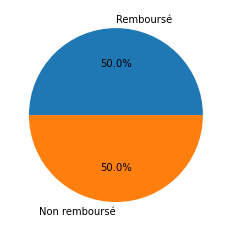

In [19]:
target_count = y_rus.value_counts()

# plot pie
plt.pie(target_count,
        autopct='%1.1f%%',
        labels=["Remboursé", "Non remboursé"]
        )
plt.show()

# Baseline

Pour une ligne de naive baseline, nous pourrions deviner la même valeur pour tous les exemples sur l'ensemble de test. On nous demande de prédire la probabilité de ne pas rembourser le prêt, donc si nous ne sommes pas du tout sûrs, nous devinerons 0,5 pour toutes les observations sur l'ensemble de test. Cela nous obtiendra une zone caractéristique de fonctionnement du récepteur sous la courbe (AUC ROC) de 0,5 dans la compétition (les devinettes aléatoires sur une tâche de classification obtiendront un 0,5).

Puisque nous savons déjà quel score nous allons obtenir, nous n'avons pas vraiment besoin de faire une estimation de base naïve. Utilisons un modèle légèrement plus sophistiqué pour notre référence actuelle : la régression logistique.

### Logistic Regression Implementation

Ici, je me concentrerai sur la mise en œuvre du modèle plutôt que sur l'explication des détails, mais pour ceux qui souhaitent en savoir plus sur la théorie des algorithmes d'apprentissage automatique, je recommande à la fois An Introduction to Statistical Learning et Hands-On Machine Learning avec Scikit-Learn et TensorFlow . Ces deux livres présentent la théorie ainsi que le code nécessaire pour créer les modèles (respectivement en R et Python). Ils enseignent tous les deux avec l'état d'esprit que la meilleure façon d'apprendre est de faire, et ils sont très efficaces ! 

Pour obtenir une ligne de base, nous utiliserons toutes les fonctionnalités après avoir encodé les variables catégorielles. Nous allons prétraiter les données en remplissant les valeurs manquantes (imputation) et en normalisant la plage des caractéristiques (mise à l'échelle des caractéristiques). Le code suivant exécute ces deux étapes de prétraitement.

Nous utiliserons LogisticRegression de Scikit-Learn pour notre premier modèle. Le seul changement que nous apporterons aux paramètres par défaut du modèle est de réduire le paramètre de régularisation, C, qui contrôle la quantité de surapprentissage (une valeur inférieure devrait diminuer le surapprentissage). Cela nous donnera des résultats légèrement meilleurs que la régression logistique par défaut, mais cela fixera toujours une barre basse pour tous les futurs modèles.

Ici, nous utilisons la syntaxe de modélisation familière de Scikit-Learn : nous créons d'abord le modèle, puis nous entraînons le modèle à l'aide de .fit, puis nous faisons des prédictions sur les données de test à l'aide de .predict_proba (rappelez-vous que nous voulons des probabilités et non un 0 ou 1) .

#### Poly

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
# Création d'un dataframe contenant les bon résultats du test 
df_results_poly = pd.DataFrame(y_test_poly.values, columns=[
                                      "true_label"], index=y_test_poly.index)

# Initialisation des prédictions
log_reg_pred = log_reg(X_rus_poly, y_rus_poly, X_test_poly, y_test_poly)

# Enregistrement des résultats des prédictions dans le dataframe
df_results_poly = save_results(
    df_results_poly, log_reg_pred, "TARGET", y_test_poly)

# transform_treshold au seuil 0.5
df_results_poly["Resultat"] = transform_treshold(
    df_results_poly["TARGET"], 0.5)

display(df_results_poly.head())
print(df_results_poly.shape)

Accuracy: 64.11%
Full AUC score: 0.66%


,true_label,TARGET,Resultat
SK_ID_CURR,,,
110508,0,0.433457,0
122512,0,0.486394,0
276634,0,0.534450,1
207755,0,0.470050,0
255865,0,0.390409,0


(30751, 3)


#### Features

In [22]:
# Création d'un dataframe contenant les bon résultats du test 
df_results_features = pd.DataFrame(y_test_feature.values, columns=[
                                      "true_label"], index=y_test_feature.index)

# Initialisation des prédictions
log_reg_pred = log_reg(X_rus, y_rus,X_test_feature, y_test_feature)

# Enregistrement des résultats des prédictions dans le dataframe
df_results_features = save_results(
    df_results_features, log_reg_pred, "TARGET", y_test_feature)

# transform_treshold au seuil 0.5
df_results_features["Resultat"] = transform_treshold(
    df_results_features["TARGET"], 0.5)

display(df_results_features.head())
print(df_results_features.shape)

Accuracy: 60.56%
Full AUC score: 0.62%


,true_label,TARGET,Resultat
SK_ID_CURR,,,
110508,0,0.472849,0
122512,0,0.512728,1
276634,0,0.519880,1
207755,0,0.486719,0
255865,0,0.459004,0


(30751, 3)


### Confusion Matrix 

In [23]:
conf_mat_poly = confusion_matrix(
    df_results_poly["true_label"], df_results_poly['Resultat'])

In [24]:
conf_mat = confusion_matrix(
    df_results_features["true_label"], df_results_features['Resultat'])

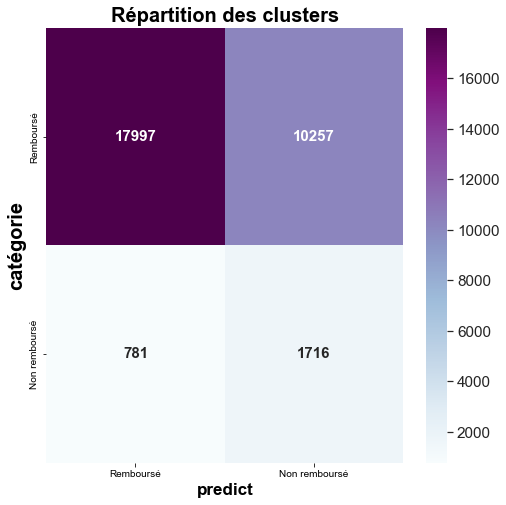

In [25]:
list_labels = ['Remboursé', 'Non remboursé']
df_cm = pd.DataFrame(conf_mat_poly, index=[label for label in list_labels],
                     columns=[label for label in list_labels])
plt.figure(figsize=(8, 8))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g')

plt.ylabel("catégorie", weight='bold', size=20)
plt.xlabel('predict', weight='bold', size=17)
plt.show()

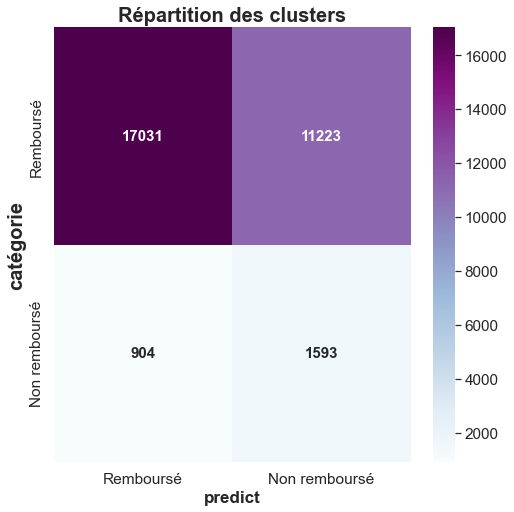

In [26]:
list_labels = ['Remboursé', 'Non remboursé']
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[label for label in list_labels])
plt.figure(figsize=(8, 8))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g')

plt.ylabel("catégorie", weight='bold', size=20)
plt.xlabel('predict', weight='bold', size=17)
plt.show()

In [27]:
#Courbe Roc
log_reg = LogisticRegression(C=0.0001).fit(X_rus_poly, y_rus_poly)
log_reg.predict(X_test_poly)
y_proba = log_reg.predict_proba(X_test_poly)[:,1]
fp_poly, tp_poly, treshold_poly = roc_curve(
    y_test_poly, y_proba)

log_reg = LogisticRegression(C=0.0001).fit(X_rus, y_rus)
log_reg.predict(X_test_feature)
y_proba_feat = log_reg.predict_proba(X_test_feature)[:,1]
fp_feat, tp_feat, treshold_feat = roc_curve(
    y_test_feature, y_proba_feat)

# roc_auc_score
valid_auc_poly = roc_auc_score(
    df_results_poly["true_label"], df_results_poly['Resultat'])
valid_auc_features = roc_auc_score(
    df_results_features["true_label"], df_results_features['Resultat'])

# Regroupement 
liste_auc_score = [("Logistic Regression_poly", valid_auc_poly),
                   ("Logistic Regression_features", valid_auc_features)]

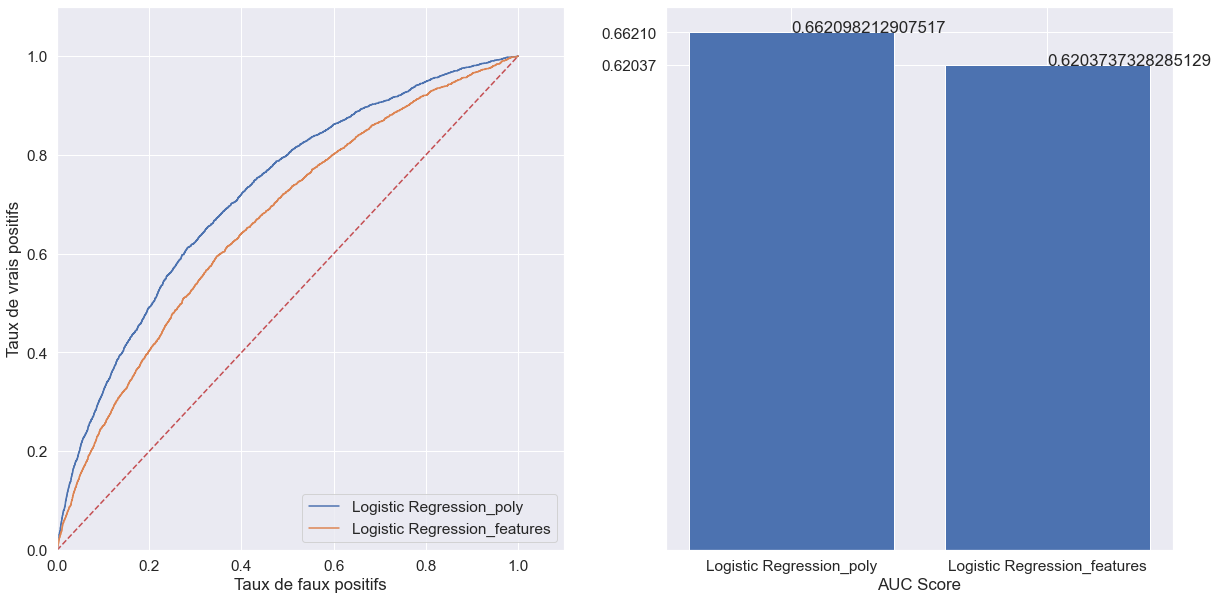

In [28]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)

plt.plot(fp_poly, tp_poly, label="Logistic Regression_poly")
plt.plot(fp_feat, tp_feat, label="Logistic Regression_features")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')

plt.subplot(1, 2, 2)

# function to add value labels
def addlabels(x,y):
    for i in range(len(xs)):
        plt.text(i,y[i],y[i])

labels, ys = zip(*liste_auc_score)

xs = np.arange(len(labels)) 

plt.bar(xs, ys)
addlabels(xs, ys)

plt.xlabel("AUC Score")
plt.xticks(xs, labels) 
plt.yticks(ys)
plt.show()

# Optimisation du modèle 

https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm Beware of categorical features in LGBM!

### Build LightGBM Model
Nous allons tester l'optimisation du modèle sur nos deux features engeenering


pour ameliorer le modèle random search comme bcp de param ou hyper opt autre package 

#### features
Dans un premier temps nous allons nous interesser au jeu de données sur le feature engeerening 

In [29]:
#Select Hyper-Parameters
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test_feature,y_test_feature)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto' 
           }

##### Initialisation de notre modèle LGBMClassifier

In [30]:
clf = lgb.LGBMClassifier(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='auc', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)

In [31]:
clf.fit(X_rus, y_rus, **fit_params)

Training until validation scores don't improve for 10 rounds
[100]	valid's auc: 0.781553
[200]	valid's auc: 0.801969
[300]	valid's auc: 0.817793
[400]	valid's auc: 0.832904
[500]	valid's auc: 0.845017
[600]	valid's auc: 0.854818
[700]	valid's auc: 0.864538
[800]	valid's auc: 0.872393
[900]	valid's auc: 0.879343
[1000]	valid's auc: 0.886275
Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.886275


LGBMClassifier(colsample_bytree=0.9, metric='auc', n_estimators=1000, n_jobs=4,
               num_leaves=15, random_state=314, subsample=0.9)

In [32]:
pickle.dump(clf,open("/Users/vincentMalfroy/Documents/GitHub/projet_7/LGBM.pkl","wb"))

In [33]:
y_hat = clf.predict(X_test_feature)
clf_pred = clf.predict_proba(X_test_feature)[:, 1]
score = roc_auc_score(y_test_feature, y_hat)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.808


In [34]:
# Création d'un dataframe contenant les bon résultats du test 
df_results_clf = pd.DataFrame(y_test_feature.values, columns=[
                                      "true_label"], index=y_test_feature.index)

# Enregistrement des résultats des prédictions dans le dataframe
df_results_clf = save_results(
    df_results_clf, clf_pred, "TARGET", y_test_feature)

# Enregistrement des résultats des prédictions dans le dataframe
df_results_clf = save_results(
    df_results_clf, y_hat, "Resultat", y_test_feature)


display(df_results_clf.head(10))
print(df_results_clf.shape)

,true_label,TARGET,Resultat
SK_ID_CURR,,,
110508,0,0.046143,0
122512,0,0.769051,1
276634,0,0.526927,1
207755,0,0.194162,0
255865,0,0.232153,0
147286,0,0.578190,1
121476,0,0.370022,0
158214,0,0.667597,1
187441,0,0.697724,1


(30751, 3)


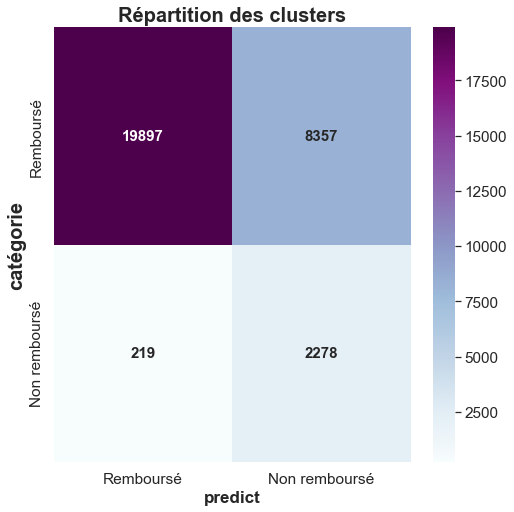

In [35]:
conf_mat_lgb = confusion_matrix(
    df_results_clf["true_label"], df_results_clf['Resultat'])

list_labels = ['Remboursé', 'Non remboursé']
df_cm = pd.DataFrame(conf_mat_lgb, index=[label for label in list_labels],
                     columns=[label for label in list_labels])
plt.figure(figsize=(8, 8))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g')

plt.ylabel("catégorie", weight='bold', size=20)
plt.xlabel('predict', weight='bold', size=17)
plt.show()

In [36]:
fp_clf, tp_clf, treshold_clf = roc_curve(y_test_feature, clf_pred)

Text(0.5, 0, 'Taux de faux positifs')

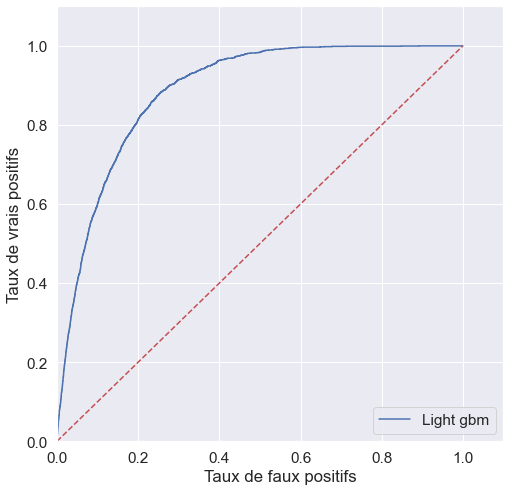

In [37]:
plt.figure(figsize=(8,8))

plt.plot(fp_clf, tp_clf, label="Light gbm")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')

## Utilisation de shap

Les valeurs SHAP (un acronyme de SHpley Additive ExPlanations) décomposent une prédiction pour montrer l'impact de chaque fonctionnalité.

In [38]:
test = data_feat.drop(columns = ['TARGET'])
id_X = df_results_clf.index

X_test_feature = pd.DataFrame(X_test_feature, columns=test.columns)
X_test_feature['SK_ID_CURR'] = id_X
X_test_feature = X_test_feature.set_index('SK_ID_CURR')

In [39]:
explainer = shap.TreeExplainer(clf)

%time shap_values = explainer.shap_values(X_test_feature)

CPU times: user 2min 37s, sys: 560 ms, total: 2min 37s
Wall time: 39.7 s


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


### Global explanation 
valeur absolu des moyennes

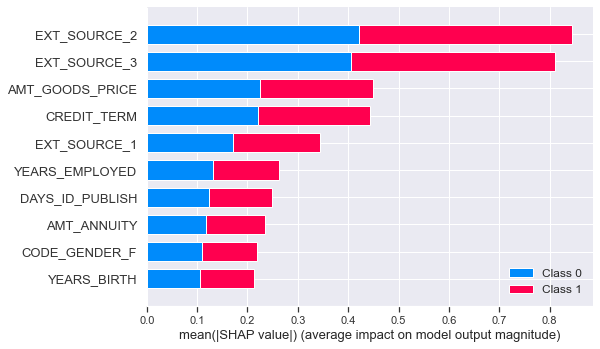

In [40]:
shap.summary_plot(shap_values, test, max_display=10)

#### Summary plot pour la classe 0

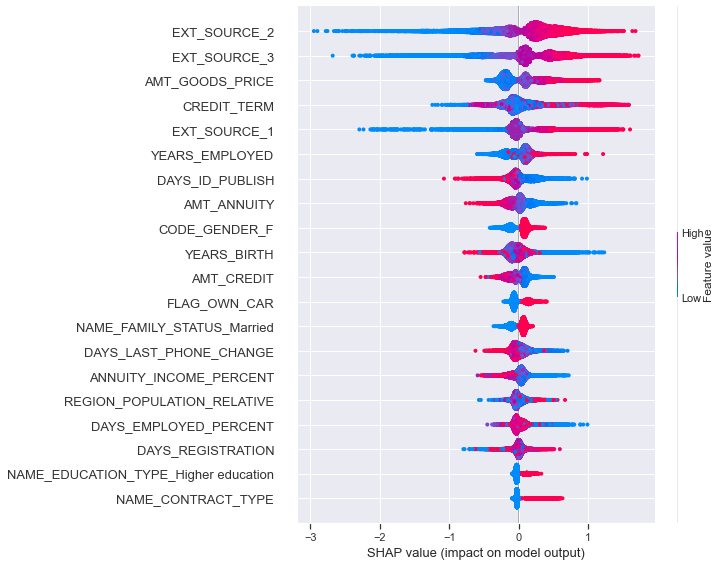

In [41]:
shap.summary_plot(shap_values[0], X_test_feature)

#### Summary plot pour la classe 1 

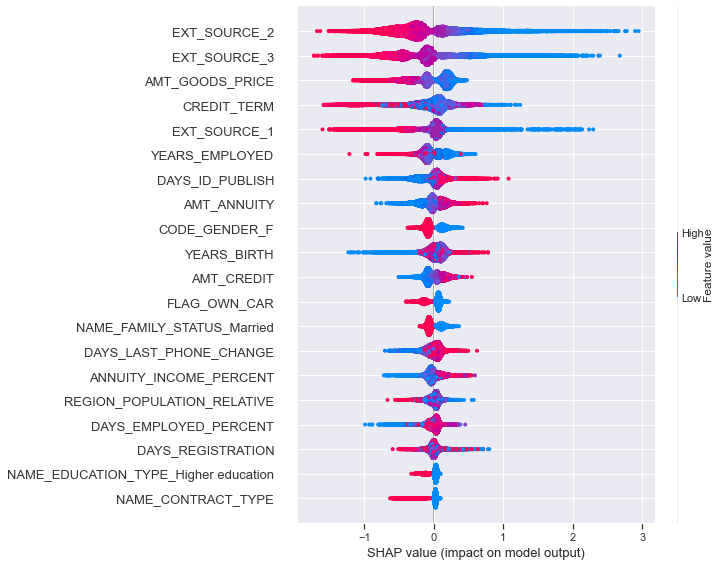

In [42]:
shap.summary_plot(shap_values[1], X_test_feature)

## Local explanation

In [48]:
row_to_show = 0
data_for_prediction = X_test_feature.iloc[row_to_show]  
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Prediction proba
print('Model prediction de la classe 0:',clf.predict_proba(data_for_prediction_array)[:,0])
print('Model prediction de la classe 1:',clf.predict_proba(data_for_prediction_array)[:,1])

#echantillonnage
n_sample = 100
X_test_feature_sample = X_test_feature.sample(n_sample)

Model prediction de la classe 0: [0.953857]
Model prediction de la classe 1: [0.046143]


Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


In [44]:
print('Model prediction:', clf.predict_proba(X_test_feature[:2], num_iteration=clf.best_iteration_)[:,1])

Model prediction: [0.046143   0.76905143]


L'objet shap_values ci-dessous est une liste avec deux tableaux. Le premier tableau est les valeurs SHAP pour un résultat négatif (ne pas rembourser), et le deuxième tableau est la liste des valeurs SHAP pour le résultat positif (rembourser). Nous pensons généralement aux prédictions en termes de prédiction d'un résultat positif, nous allons donc extraire les valeurs SHAP pour les résultats positifs (retirer shap_values[1]).

### Création d'une fonction pour afficher le shap.force_plot
Target 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé

In [52]:
def credit_factors(model, patient,data):

    explainer = shap.KernelExplainer(model, data)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

Nous allons nous interesser à la target 1 : non remboursement du pret 

In [54]:
data_for_prediction = X_test_feature.iloc[0,:]
credit_factors(clf.predict_proba, data_for_prediction,X_test_feature_sample)

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


In [55]:
data_for_prediction = X_test_feature.iloc[2,:]
credit_factors(clf.predict_proba, data_for_prediction,X_test_feature_sample)

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


In [56]:
data_for_prediction = X_test_feature.iloc[3,:]
credit_factors(clf.predict_proba, data_for_prediction,X_test_feature_sample)

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


####                       Modèle poly

In [57]:
clf_poly = lgb.LGBMClassifier(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='auc', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1).fit(X_rus_poly, y_rus_poly)

In [58]:
y_hat_poly = clf_poly.predict(X_test_poly)
clf_pred = clf_poly.predict_proba(X_test_poly)[:, 1]
score = roc_auc_score(y_test_poly, y_hat_poly)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.815


In [59]:
# Création d'un dataframe contenant les bon résultats du test 
df_results_poly = pd.DataFrame(y_test_poly.values, columns=[
                                      "true_label"], index=y_test_poly.index)

# Enregistrement des résultats des prédictions dans le dataframe
df_results_poly = save_results(
    df_results_poly, clf_pred, "TARGET", y_test_poly)

# Enregistrement des résultats des prédictions dans le dataframe
df_results_poly = save_results(
    df_results_poly, y_hat_poly, "Resultat", y_test_poly)


display(df_results_poly.head())
print(df_results_poly.shape)

,true_label,TARGET,Resultat
SK_ID_CURR,,,
110508,0,0.014981,0
122512,0,0.247522,0
276634,0,0.543404,1
207755,0,0.399557,0
255865,0,0.172601,0


(30751, 3)


## Utilisation de shap

Les valeurs SHAP (un acronyme de SHpley Additive ExPlanations) décomposent une prédiction pour montrer l'impact de chaque fonctionnalité.

### Global explanation 

In [60]:
poly = data_log.drop(columns = ['TARGET'])
X_test_poly = pd.DataFrame(X_test_poly, columns=poly.columns)

In [61]:
explainer = shap.TreeExplainer(clf_poly)

%time shap_values = explainer.shap_values(X_test_poly)

CPU times: user 2min 40s, sys: 572 ms, total: 2min 40s
Wall time: 40.6 s


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


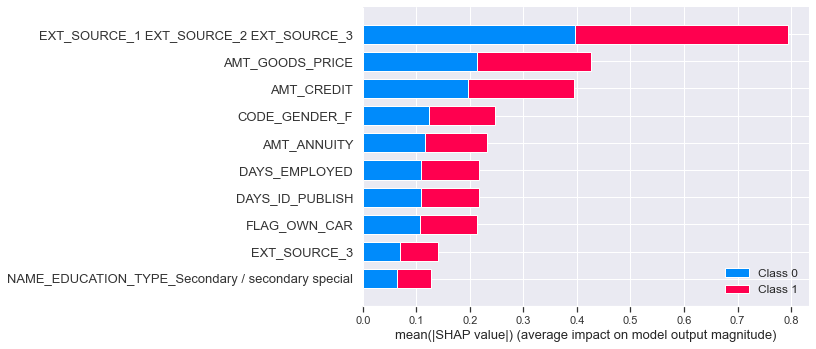

In [62]:
shap.summary_plot(shap_values, poly, max_display=10)

### Summary plot pour la classe 1

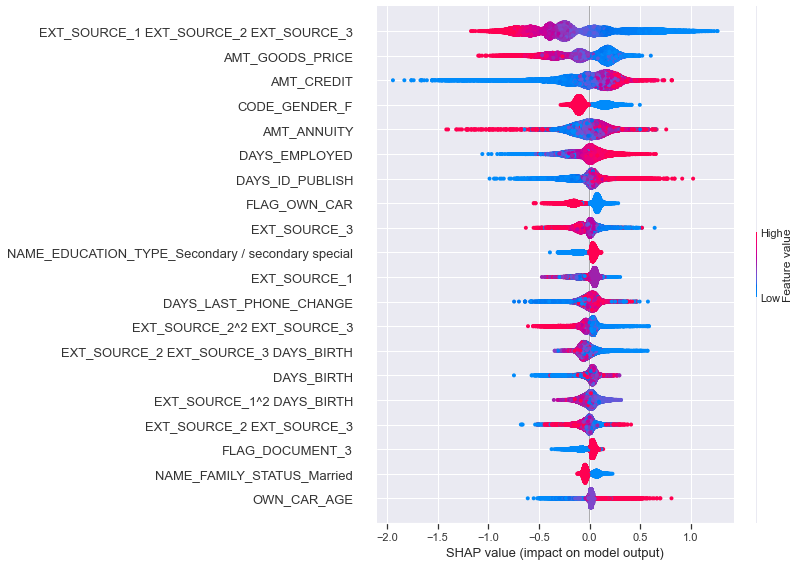

In [63]:
shap.summary_plot(shap_values[1], X_test_poly)

### Summary plot pour la classe 0

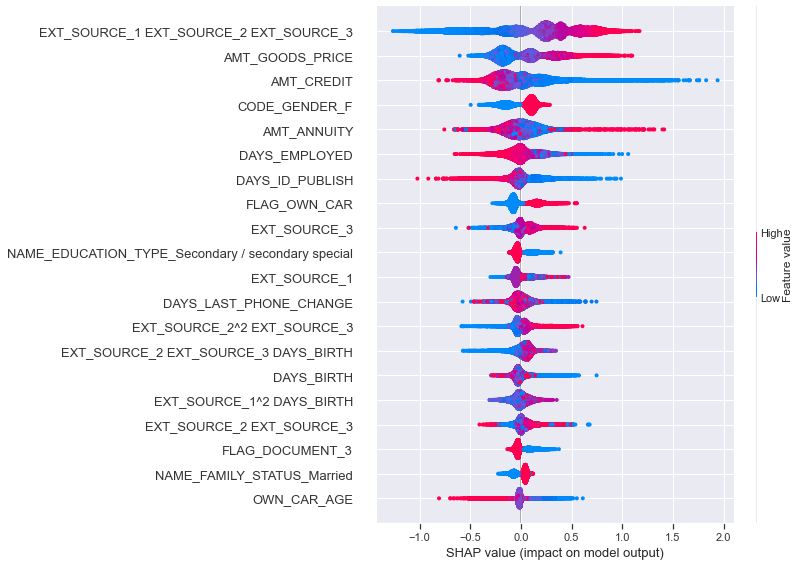

In [64]:
shap.summary_plot(shap_values[0], X_test_poly)

## Local explanation
Target 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé

In [65]:
row_to_show = 0
data_for_prediction = X_test_poly.iloc[row_to_show] 
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

#Predict proba 
print('Model prediction de la classe 0:',clf_poly.predict_proba(data_for_prediction_array)[:,0])
print('Model prediction de la classe 1:',clf_poly.predict_proba(data_for_prediction_array)[:,1])

# Sample 
n_sample = 100
X_test_poly_sample = X_test_poly.sample(n_sample)
X_test_poly_sample.shape

Model prediction de la classe 0: [0.9850185]
Model prediction de la classe 1: [0.0149815]


(100, 272)

In [66]:
data_for_prediction = X_test_poly.iloc[0,:]
credit_factors(clf_poly.predict_proba, data_for_prediction,X_test_poly_sample)

In [67]:
data_for_prediction = X_test_poly.iloc[1,:]
credit_factors(clf_poly.predict_proba, data_for_prediction,X_test_poly_sample)

In [68]:
data_for_prediction = X_test_poly.iloc[2,:]
credit_factors(clf_poly.predict_proba, data_for_prediction,X_test_poly_sample)

## Exportation de nos deux jeux de données 
Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke un echantillon de 30 individus et un deuxième dataset avec la totalité des individus pour la prédiction

In [69]:
compres = dict(method='zip', archive_name='client_information.csv')
X_test_feature.to_csv('client_information.zip', index=True, compression=compres)

In [70]:
X_test_feature.to_csv(
    '/Users/vincentMalfroy/Documents/GitHub/projet_7/client_information.csv',
    index=True)

In [71]:
X_test_feature_sample = X_test_feature.iloc[:30,:]

compres = dict(method='zip', archive_name='client_information_sample.csv')
X_test_feature_sample.to_csv('client_information_sample.zip', index=True, compression = compres)

In [72]:
X_test_feature_sample.to_csv(
    '/Users/vincentMalfroy/Documents/GitHub/projet_7/client_information_sample.csv',
    index=True)